In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
text_df = pd.read_csv("./df_file.csv") #./df_file.csv, /content/drive/MyDrive/df_file.csv

X = text_df['Text']
y = text_df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [13]:
#Export vectorizer
joblib.dump(vectorizer, "./vectorizer.pkl")

['./vectorizer.pkl']

In [4]:
# Define the XGBoost model for text classification
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(set(y)), random_state=42) #, tree_method = "hist", device = "cuda"

In [5]:
# Define the hyperparameter grid for random search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5]
}

In [6]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid,
                                   n_iter=10, scoring='accuracy', cv=kf,
                                   verbose=2, random_state=42, n_jobs=-1)

In [8]:
# Fit the model with random search using TF-IDF features
random_search.fit(X_train_tfidf, y_train)

print("Best Hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Hyperparameters: {'subsample': 0.6, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.2, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [12]:
#Export model
joblib.dump(random_search, "./xgboost.pkl")

['./xgboost.pkl']

In [9]:
# Make predictions on the test set using the best model
y_pred = random_search.best_estimator_.predict(X_test_tfidf)

In [10]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

# Additional evaluation metrics (classification report)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy on Test Set: 0.9573033707865168
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96        92
           1       0.99      0.98      0.98        98
           2       0.97      0.95      0.96        77
           3       0.92      0.95      0.94        76
           4       0.94      0.95      0.95       102

    accuracy                           0.96       445
   macro avg       0.96      0.96      0.96       445
weighted avg       0.96      0.96      0.96       445



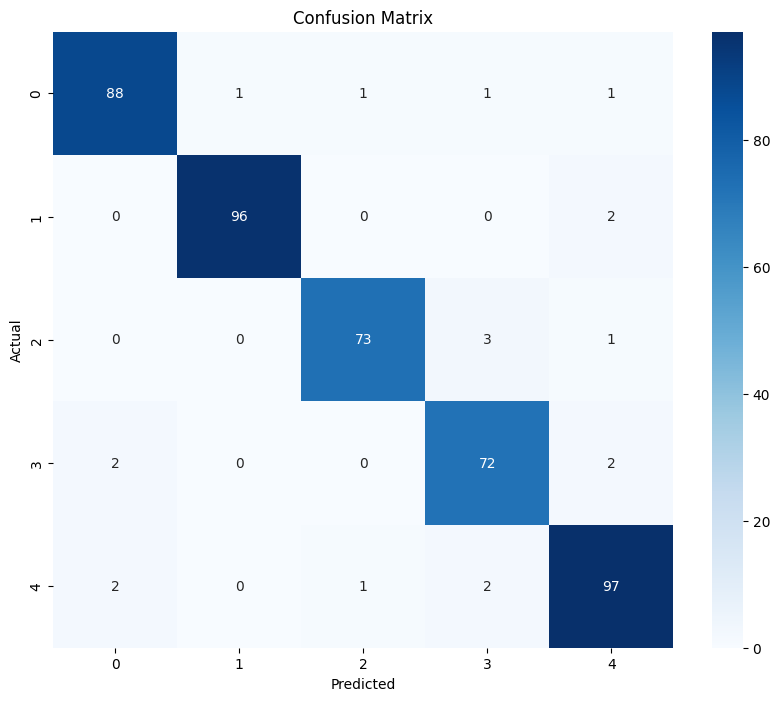

In [11]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Extract indices of misclassified instances
misclassified_indices = [i for i, (true_label, pred_label) in enumerate(zip(y_test, y_pred)) if true_label != pred_label]

# Extract misclassified instances
misclassified_data = text_df.iloc[misclassified_indices].copy()
misclassified_data['Predicted Label'] = y_pred[misclassified_indices]

In [26]:
# Display misclassified instances
print("Misclassified Instances:")
print(misclassified_data[['Text', 'Label', 'Predicted Label']])

Misclassified Instances:
                                                  Text  Label  Predicted Label
2    Howard denies split over ID cards\n \n Michael...      0                0
4    Kilroy names election seat target\n \n Ex-chat...      0                3
24   'Hitler' row over Welsh arts cash\n \n An arti...      0                1
85   What the election should really be about?\n \n...      0                0
92   Tories pledge free sports lessons\n \n Childre...      0                3
106  McConnell in 'drunk' remark row\n \n Scotland'...      0                4
138  Chancellor rallies Labour voters\n \n Gordon B...      0                4
153  Labour targets 'hardcore truants'\n \n A fresh...      0                2
203  Visa row mandarin made Sir John\n \n The top c...      0                0
228  Taxes must be trusted - Kennedy\n \n Public tr...      0                2
290  CSA chief who 'quit' still in job\n \n The hea...      0                4
304  Brown comes out shooti

In [5]:
# Load pre-trained XGBoost model
xgb_model = joblib.load("./xgboost.pkl")

# Load TF-IDF vectorizer
vectorizer = joblib.load("./vectorizer.pkl")

test_df = pd.read_csv("./TestDataUnseen.csv", delimiter=';')

text_tfidf = vectorizer.transform(test_df["Text"])

prediction = xgb_model.predict(text_tfidf)[0]

AttributeError: Can't get attribute '_PredictScorer' on <module 'sklearn.metrics._scorer' from 'C:\\Users\\ROB7824\\AppData\\Roaming\\Python\\Python310\\site-packages\\sklearn\\metrics\\_scorer.py'>